In [ ]:
!pip install wandb

In [2]:
# login into wandb for experiment logging
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import os
import math
import json

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import PIL
import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import autograd

SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [66]:
class Config:
    @classmethod
    def from_dict(cls, entries):
        """NOTE: this method doesn't check correctness of variable names"""
        obj = cls()
        obj.__dict__.update(entries)
        return obj

    def to_dict(self):
        raw_dict = self.__dict__
        return {(k, v) for k, v in raw_dict.items() if k.isupper()}

params = {
    "N_SAMPLES": 1024, # number of samples in batch
    "N_STEPS": 175, # number of langevin steps
    "STEP_SIZE": 1., # langevin step size
    "SAMPLING_NOISE": 0.04, # langevin noise variance
    "ALPHA": 0, # coef. for potential norm regularization
    #"GAMMA": 0.01, # hyperparameter prob measure integrable on R (b)
    "HREG": 1., # aka eps (parametrization of entropy)
    "HREG_DECAY": False, # if true, apply decay from large value to target HREG
    "BUFFER_SIZE": None, # replay buffer size
    "SCALED_REGIME": True, # apply std scale to X and Y
    "N_ITERS": 250, # number of training epochs
    "HIDDEN_DIM_SIZE": 256,
    "OPT_TYPE": torch.optim.Adam,
    "OPT_KWARGS": {
        "lr": 2e-4,
    },
}

config = Config.from_dict(params)

In [ ]:
# init wandb project with created config
wandb.init(
    project="ebm-ot-gaus-swissroll",
    config=params
)

# Data

In [30]:
def generate_gauss_2d_dataset(mu, sigma, n_samples):
    samples = np.random.normal(
        loc=mu, scale=sigma, size=(n_samples, 2)).astype(np.float32)
    return samples


def generate_swissroll(scale, noise, n_samples):
    samples, _ = sklearn.datasets.make_swiss_roll(
        n_samples, noise=noise, random_state=SEED)
    return samples[:, (0, 2)].astype(np.float32)*scale


def std_scale(data, mu, std):
    return (data - mu)/std


def std_scale_inv(data, mu, std):
    return data*std + mu


class GaussDataset(Dataset):
    def __init__(self, mu=0, sigma=1, n_samples=1000, sample_scaled=config.SCALED_REGIME):
        super().__init__()
        self.data = torch.from_numpy(
            generate_gauss_2d_dataset(mu, sigma, n_samples)).to(DEVICE)

        self.mu = self.data.mean(dim=0)
        self.std = self.data.std(dim=0)

        self.sample_scaled = sample_scaled

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

    def sample(self, n):
        sample = torch.stack(
            list(self.data[np.random.randint(low=0, high=len(self.data))]
                 for _ in range(n))
        )
        if self.sample_scaled:
            sample = std_scale(sample, self.mu, self.std)
        return sample


class SwissrollDataset(Dataset):
    def __init__(self, scale=1, noise=0.75, n_samples=1000, sample_scaled=config.SCALED_REGIME):
        super().__init__()
        self.data = torch.from_numpy(generate_swissroll(
            scale, noise, n_samples)).to(DEVICE)

        self.mu = self.data.mean(dim=0)
        self.std = self.data.std(dim=0)

        self.sample_scaled = sample_scaled

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

    def sample(self, n):
        sample = torch.stack(
            list(self.data[np.random.randint(low=0, high=len(self.data), size=n)])
        )
        if self.sample_scaled:
            sample = std_scale(sample, self.mu, self.std)
        return sample

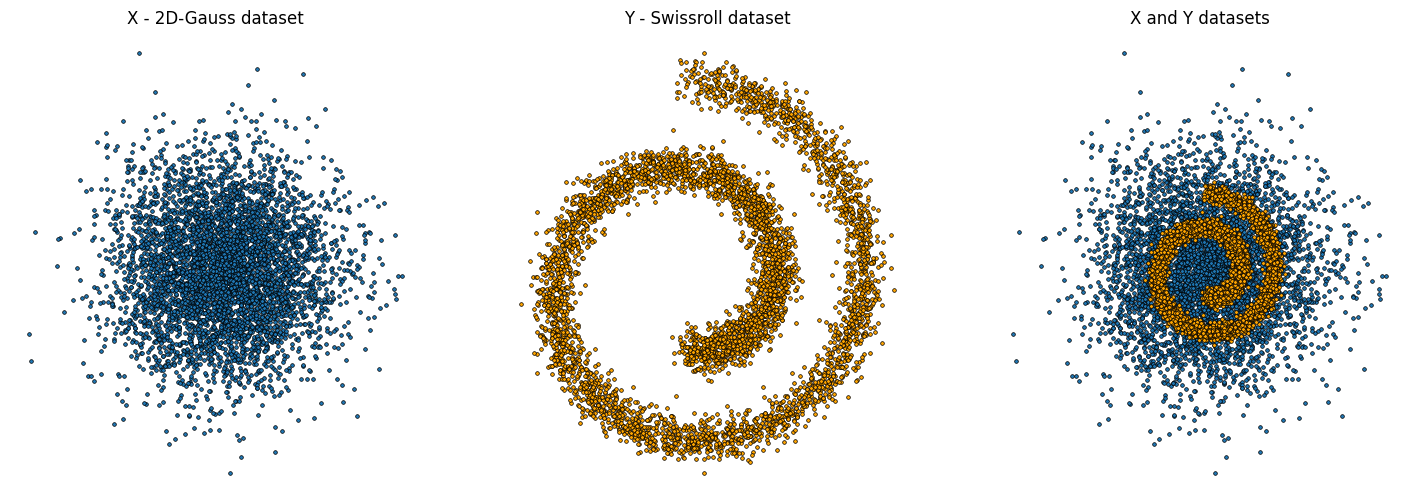

In [31]:
dataset_x = GaussDataset(n_samples=5000, sigma=1.)
dataset_y = SwissrollDataset(n_samples=5000, scale=0.1)

_, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(dataset_x.data[:, 0].cpu(),
               dataset_x.data[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5)
axs[0].set_title("X - 2D-Gauss dataset")
axs[0].axis('off')

axs[1].scatter(dataset_y.data[:, 0].cpu(), dataset_y.data[:,
               1].cpu(), c='orange', s=7, marker='o', edgecolors='black', linewidths=0.5)
axs[1].set_title("Y - Swissroll dataset")
axs[1].axis('off')

axs[2].scatter(dataset_x.data[:, 0].cpu(),
               dataset_x.data[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5)
axs[2].scatter(dataset_y.data[:, 0].cpu(), dataset_y.data[:,
               1].cpu(), c='orange', s=7, marker='o', edgecolors='black', linewidths=0.5)
axs[2].set_title("X and Y datasets")
axs[2].axis('off')

plt.show()

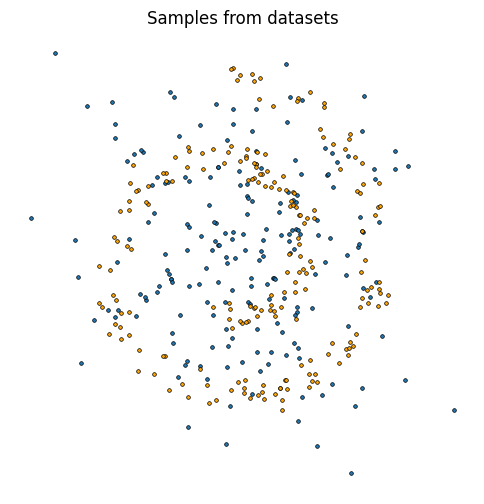

In [8]:
plt.figure(figsize=(6, 6))

sample_x = dataset_x.sample(n=200)
sample_y = dataset_y.sample(n=200)

plt.scatter(sample_x[:, 0].cpu(), sample_x[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5)
plt.scatter(sample_y[:, 0].cpu(), sample_y[:,1].cpu(), c='orange', s=7, marker='o', edgecolors='black', linewidths=0.5)
plt.title("Samples from datasets")
plt.axis('off')

plt.show()

# Models and training

## Utility functionality

In [47]:
class BasicMLP(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.mlp(x)


class HREG_Scheduler:
    """Scheduler for HREG value through langevin steps - in order to make langevin more stable,
    introduce exponential decay from large value (making cost gradient small)
    to desired value"""
    hreg_0 = config.HREG
    hreg_m = 10_000 # arbitrary large value to start decay from
    tau = 20 # parameter of exponential decay (larger => steeper)

    @classmethod
    def get_hreg(cls, t):
        return cls.hreg_0 + cls.hreg_m*math.exp(-t/cls.tau)


class ReplayBuffer:
    """Joint replay buffer for x and y efficient sampling during langevin.

    Usage:
    ```
    buffer = ReplayBuffer(buffer_size=10_000)
    x, y = buffer.get_n_samples(1024)
    ... # langvein updates => x_new, y_new
    buffer.update(x_new, y_new)
    ```
    """
    def __init__(self, buffer_size=config.BUFFER_SIZE, shape=2):
        self._size = buffer_size
        self._buffer = torch.normal(0, 3., size=(buffer_size, 2, shape))
        self._buffer.requires_grad_ = False
        self._selected_indices = None

    def get_n_samples(self, n):
        self._selected_indices = np.random.choice(list(range(self._size)), size=n, replace=False)
        return self._buffer[self._selected_indices, 0].to(DEVICE), self._buffer[self._selected_indices, 1].to(DEVICE)

    def update(self, new_x, new_y):
        if self._selected_indices is None:
            raise ValueError("Error: you haven't sampled yet!")
        with torch.no_grad():
            self._buffer[self._selected_indices, 0] = new_x.cpu()
            self._buffer[self._selected_indices, 1] = new_y.cpu()
        self._selected_indices = None

    def visualize(self, return_img=True):
        plt.figure()

        x, y = self._buffer[:, 0, :], self._buffer[:, 1, :]
        plt.scatter(x[:, 0], x[:, 1], s=7, marker='o', edgecolors='black', linewidths=0.5)
        plt.scatter(y[:, 0], y[:, 1], c='red', s=7, marker='o', edgecolors='black', linewidths=0.5)

        if not return_img:
            plt.show()
        else:
            img_buf = io.BytesIO()
            plt.savefig(img_buf, format='png')
            plt.close()
            return PIL.Image.open(img_buf)


def function_grad(f_out, arg, *args):
    """function gradient w.r.t input argumnets (support for batch-dim)"""
    grad = autograd.grad(
        outputs=f_out,
        inputs=arg,
        grad_outputs=torch.ones_like(f_out),
        create_graph=True,
        retain_graph=True
    )[0]
    return grad

1.8481823524646916 1.0


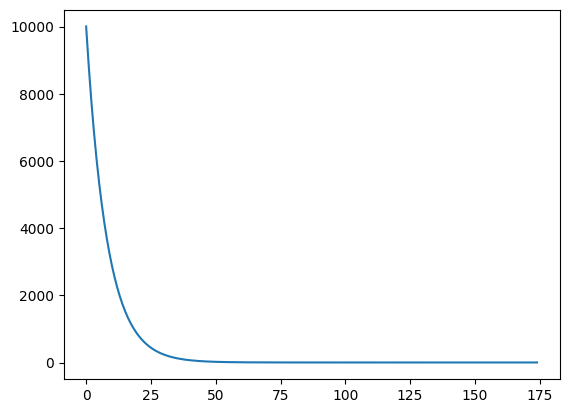

In [56]:
# hreg scheduling demo
HREG_Scheduler.tau=8
values = [HREG_Scheduler.get_hreg(t) for t in range(config.N_STEPS)]
print(values[-100], config.HREG)
plt.plot(values)
plt.show()

## Model, sampling, training

In [57]:
class BasicModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.mlp = BasicMLP(hidden_dim)

    def forward(self, x):
        return self.mlp(x)


def c(x, y):
    """Wasserstein-2 distance"""
    return 0.5*torch.pow(torch.norm(x - y), 2)


### Langevin related function with configured coef. for each component ###
@torch.enable_grad
def get_potential_score(f, inp):
    """potential score w.r.t. inp"""
    inp.requires_grad_(True)
    POTENTIAL_COEF = 1.
    f_out = f(inp)
    score = function_grad(f_out, inp)
    return POTENTIAL_COEF * score


@torch.enable_grad
def get_cost_score(inp1, inp2, t):
    """cost score w.r.t inp1"""
    inp1.requires_grad_(True)
    if config.HREG_DECAY:
        COST_COEF = config.SAMPLING_NOISE**2/HREG_Scheduler.get_hreg(t)
    else:
        COST_COEF = config.SAMPLING_NOISE**2/config.HREG
    cost = c(inp1, inp2)
    score = function_grad(cost, inp1)
    return COST_COEF * score
##########################################################################


def sample_from_joint_pi_theta(
        u_model,
        v_model,
        n_samples=config.N_SAMPLES,
        num_steps=config.N_STEPS,
        sampling_noise=config.SAMPLING_NOISE,
        buffer=None
    ):
    u_model.eval()
    v_model.eval()

    if buffer is None:
        x, y = torch.normal(0, 1., size=(2*n_samples, 2), device=DEVICE).split(n_samples, dim=0)
    else:
        x, y = buffer.get_n_samples(n_samples)

    for t in range(num_steps):
        energy_grad_x = get_potential_score(u_model, x) - get_cost_score(x, y, t)
        energy_grad_y = get_potential_score(v_model, y) - get_cost_score(y, x, t)

        z = torch.randn_like(x, device=DEVICE)

        # perform langevin step
        x = x + 0.5 * energy_grad_x + sampling_noise * z
        y = y + 0.5 * energy_grad_y + sampling_noise * z

    if buffer is not None:
        buffer.update(x, y)

    u_model.train()
    v_model.train()
    return x, y


def sample_conditional(
        model, # potential function
        x_start, # point, on which sampling is conditioned
        n_samples,
        n_steps=config.N_STEPS,
        sampling_noise=config.SAMPLING_NOISE,
        hreg=config.HREG,
    ):
    """inference algorithm for conditional sampling from ebm given point from one domain to other"""
    model.eval()
    x = torch.broadcast_to(x_start, (n_samples, 2))
    y = torch.normal(0, 1., size=x.shape, device=DEVICE)
    noise = sampling_noise
    for t in range(n_steps):
        energy_grad = get_potential_score(model, y) - get_cost_score(y, x, t)
        z = torch.randn_like(x, device=DEVICE)
        y = y + 0.5 * energy_grad + noise * z

    return y

## Visualization tools

In [58]:
def visualize_joint_distribution(u, v, n_samples, return_img=False):
    plt.figure()

    x, y = sample_from_joint_pi_theta(u, v, n_samples)
    x, y = x.cpu().detach().numpy(), y.cpu().detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], s=7, marker='o', edgecolors='black', linewidths=0.5)
    plt.scatter(y[:, 0], y[:, 1], c='red', s=7, marker='o', edgecolors='black', linewidths=0.5)

    if not return_img:
        plt.show()
    else:
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')
        plt.close()
        return PIL.Image.open(img_buf)


def visualize_learned_distribution(model, dataset_from, dataset_to, return_img=False):
    """Visualizes mapping for each point from one domain to another (conditional transport)"""
    if config.SCALED_REGIME:
        ds_x = std_scale(dataset_from.data, dataset_from.mu, dataset_from.std)
        ds_y = std_scale(dataset_to.data, dataset_to.mu, dataset_to.std)
    else:
        ds_x = dataset_from.data
        ds_y = dataset_to.data
    learned_projection = sample_conditional(
        model,
        ds_x,
        n_samples=len(dataset_from)
    )
    learned_projection = learned_projection.cpu().detach().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].scatter(ds_x[:, 0].cpu(),
                   ds_x[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5)
    axs[0].set_title("Original distribution")
    axs[0].axis('off')

    axs[1].scatter(learned_projection[:, 0], learned_projection[:,
                                                                1], c='red', s=7, marker='o', edgecolors='black', linewidths=0.5)
    axs[1].set_title("Fitted distribution")
    axs[1].axis('off')

    axs[2].scatter(ds_y[:, 0].cpu(),
                   ds_y[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5, alpha=0.8)
    axs[2].scatter(learned_projection[:, 0], learned_projection[:,
                                                                1], c='red', s=7, marker='o', edgecolors='black', linewidths=0.5, alpha=0.5)
    axs[2].set_title("Target distribution + Fitted distribution")
    axs[2].axis('off')

    if not return_img:
        plt.show()
    else:
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')
        plt.close()
        return PIL.Image.open(img_buf)

## Training

In [59]:
def train(
        dataset_x,
        dataset_y,
        u_model,
        v_model,
        optimizer,
        num_iters=config.N_ITERS,
        alpha=config.ALPHA,
    ):
    loss_hist = []

    if config.HREG_DECAY:
        hreg_scheduler = HREG_Scheduler()

    if config.BUFFER_SIZE is not None:
        buffer = ReplayBuffer(buffer_size=config.BUFFER_SIZE)
    else:
        buffer = None

    with tqdm(range(num_iters), unit='iter') as titer:
        for t in titer:
            optimizer.zero_grad()
            x_samples_true = dataset_x.sample(config.N_SAMPLES)
            y_samples_true = dataset_y.sample(config.N_SAMPLES)

            x_samples_lg, y_samples_lg = sample_from_joint_pi_theta(u_model, v_model, buffer=buffer)

            pos_out = u_model(x_samples_true) + v_model(y_samples_true)
            neg_out = u_model(x_samples_lg) + v_model(y_samples_lg)
            potential_reg = alpha * (pos_out**2 + neg_out**2).mean() #(d-3)

            loss = -pos_out.mean() + neg_out.mean() + potential_reg

            loss.backward()
            optimizer.step()

            loss_hist.append(loss.item())
            titer.set_postfix(loss=loss_hist[-1])

            wandb.log({"loss": loss_hist[-1]})

            if (t + 1) % 10 == 0: # visual logging
                u_model.eval()
                v_model.eval()

                viz_res = {}
                viz_res["joint_samples_viz"] = wandb.Image(visualize_joint_distribution(u_model, v_model, n_samples=config.N_SAMPLES, return_img=True))

                if buffer is not None:
                    viz_res["replay_buffer_content"] = wandb.Image(buffer.visualize(return_img=True))

                wandb.log(viz_res)

                u_model.train()
                v_model.train()

    return loss_hist

In [68]:
u_model = BasicModel(hidden_dim=config.HIDDEN_DIM_SIZE).to(DEVICE)
v_model = BasicModel(hidden_dim=config.HIDDEN_DIM_SIZE).to(DEVICE)

optimizer = config.OPT_TYPE(
    list(u_model.parameters()) + list(v_model.parameters()),
    **config.OPT_KWARGS
)
plt.ioff() # turn off interactive plotting here
loss_hist = train(dataset_x, dataset_y, u_model, v_model,
                  optimizer, num_iters=config.N_ITERS)


# ater training finished, save conditional visualizations for complete datasets
wandb.log({
    "visualize_conditional_x2y": wandb.Image(visualize_learned_distribution(
        u_model, dataset_y, dataset_x, return_img=True
    )),
    "visalize_conditional_y2x": wandb.Image(visualize_learned_distribution(
        v_model, dataset_x, dataset_y, return_img=True
    )),
})

100%|██████████| 250/250 [03:47<00:00,  1.10iter/s, loss=0.000333]


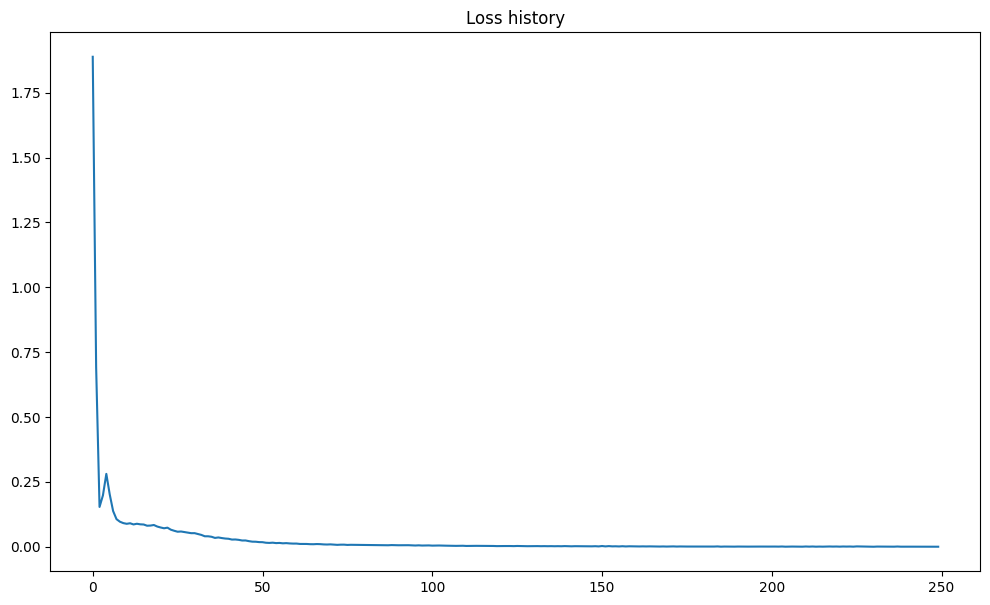

In [69]:
plt.figure(figsize=(12, 7))
plt.plot(loss_hist)
plt.title("Loss history")
plt.show()

# Results

## Fitted dataset vs Target comparison

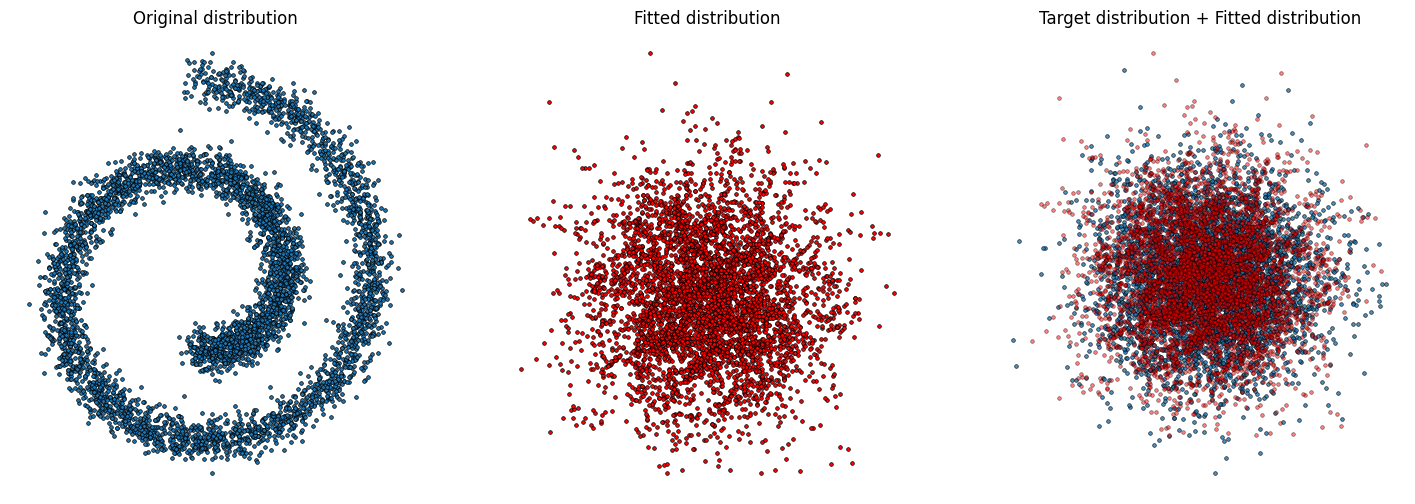

In [72]:
visualize_learned_distribution(u_model, dataset_y, dataset_x)

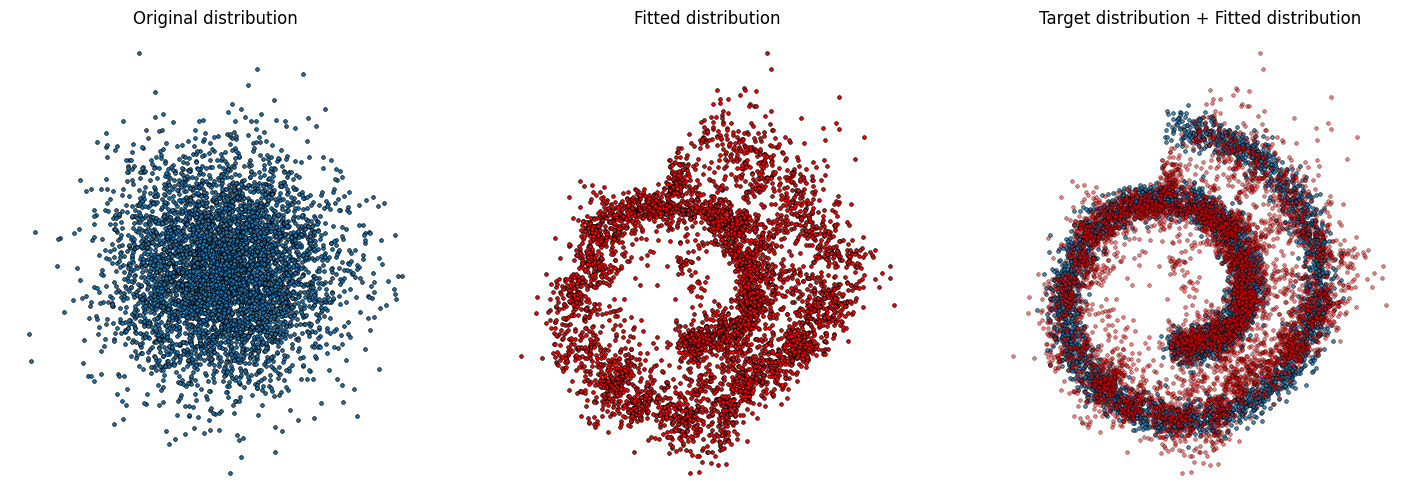

In [73]:
visualize_learned_distribution(v_model, dataset_x, dataset_y)

## Conditional plans

In [ ]:
def visualize_sampling_cond_from_points(model, dataset1, dataset2, n=1, samples=50, swap_colors=False, scale_axis=False, title="Sampling from random points"):
    x_start = dataset1.sample(n)
    y_sampled = sample_conditional(model, x_start, n*samples)

    if config.SCALED_REGIME:
        x_start = std_scale_inv(x_start, dataset1.mu, dataset1.std)
        y_sampled = std_scale_inv(y_sampled, dataset2.mu, dataset2.std)

    x_start = x_start.cpu().detach().numpy()
    y_sampled = y_sampled.cpu().detach().numpy()

    c1, c2 = ('skyblue', 'orange') if not swap_colors else (
        'orange', 'skyblue')

    ds1_data = dataset1.data
    ds2_data = dataset2.data

    plt.figure(figsize=(8, 8))
    plt.scatter(ds1_data[:, 0].cpu(), ds1_data[:, 1].cpu(),
                c=c1, s=5, marker='o', alpha=0.2)
    plt.scatter(ds2_data[:, 0].cpu(), ds2_data[:, 1].cpu(),
                c=c2, s=5, marker='o', alpha=0.2)

    plt.scatter(x_start[:, 0], x_start[:, 1], c='red', s=20, marker='o', edgecolors='black', linewidths=1.)
    plt.scatter(y_sampled[:, 0], y_sampled[:, 1], c='red',
                s=25, marker='x')

    for i in range(len(y_sampled)):
        plt.plot([x_start[0, 0], y_sampled[i, 0]], [
                 x_start[0, 1], y_sampled[i, 1]], c='red', alpha=0.2)

    if scale_axis:
        # scale plt around sampled points
        x_min = np.min(y_sampled[:, 0])
        x_max = np.max(y_sampled[:, 0])
        y_min = np.min(y_sampled[:, 1])
        y_max = np.max(y_sampled[:, 1])

        plt.xlim(x_min - 0.1*(x_max - x_min), x_max + 0.1*(x_max - x_min))
        plt.ylim(y_min - 0.1*(y_max - y_min), y_max + 0.1*(y_max - y_min))

    plt.title(title)
    plt.show()

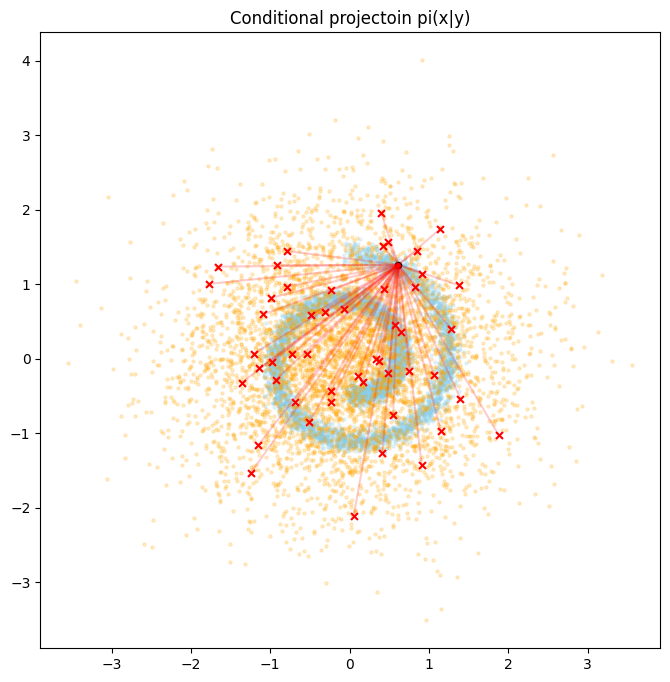

In [ ]:
visualize_sampling_cond_from_points(u_model, dataset_y, dataset_x,
                                    title="Conditional projectoin pi(x|y)")

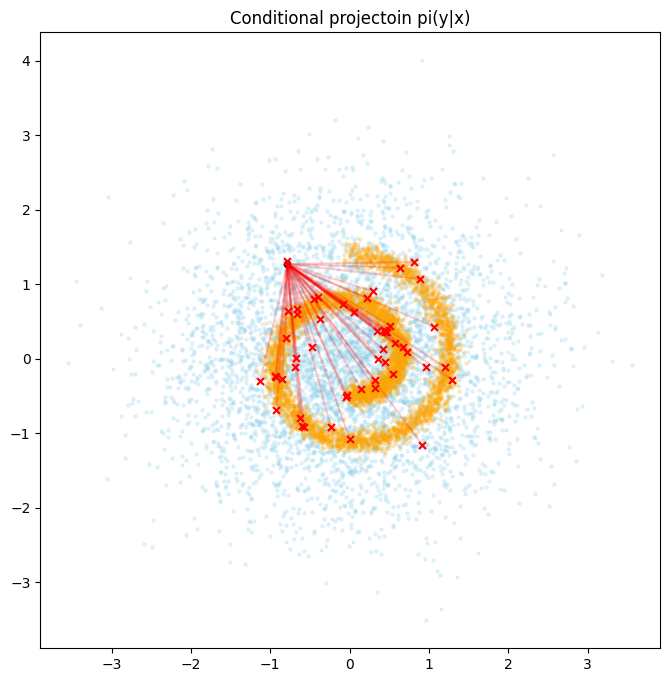

In [ ]:
visualize_sampling_cond_from_points(v_model, dataset_x, dataset_y,
                                    title="Conditional projectoin pi(y|x)")

## Set of random 1 to 1 projections

In [ ]:
def visualize_sampling_cond_from_points_1to1(model, dataset1, dataset2, n=1, swap_colors=False, scale_axis=False, title="Sampling from random points"):
    x_start = dataset1.sample(n)
    y_sampled = sample_conditional(model, x_start, n)

    if config.SCALED_REGIME:
        x_start = std_scale_inv(x_start, dataset1.mu, dataset1.std)
        y_sampled = std_scale_inv(y_sampled, dataset2.mu, dataset2.std)

    x_start = x_start.cpu().detach().numpy()
    y_sampled = y_sampled.cpu().detach().numpy()

    c1, c2 = ('skyblue', 'orange') if not swap_colors else (
        'orange', 'skyblue')

    ds1_data = dataset1.data
    ds2_data = dataset2.data

    plt.figure(figsize=(8, 8))
    plt.scatter(ds1_data[:, 0].cpu(), ds1_data[:, 1].cpu(),
                c=c1, s=5, marker='o', alpha=0.2)
    plt.scatter(ds2_data[:, 0].cpu(), ds2_data[:, 1].cpu(),
                c=c2, s=5, marker='o', alpha=0.2)

    plt.scatter(x_start[:, 0], x_start[:, 1], c='red', s=20,
                marker='o', edgecolors='black', linewidths=1.)
    plt.scatter(y_sampled[:, 0], y_sampled[:, 1], c='red',
                s=25, marker='x')

    for i in range(len(y_sampled)):
        plt.plot([x_start[i, 0], y_sampled[i, 0]], [
                 x_start[i, 1], y_sampled[i, 1]], c='red', alpha=0.2)

    if scale_axis:
        # scale plt around sampled points
        x_min = np.min(y_sampled[:, 0])
        x_max = np.max(y_sampled[:, 0])
        y_min = np.min(y_sampled[:, 1])
        y_max = np.max(y_sampled[:, 1])

        plt.xlim(x_min - 0.1*(x_max - x_min), x_max + 0.1*(x_max - x_min))
        plt.ylim(y_min - 0.1*(y_max - y_min), y_max + 0.1*(y_max - y_min))

    plt.title(title)
    plt.show()

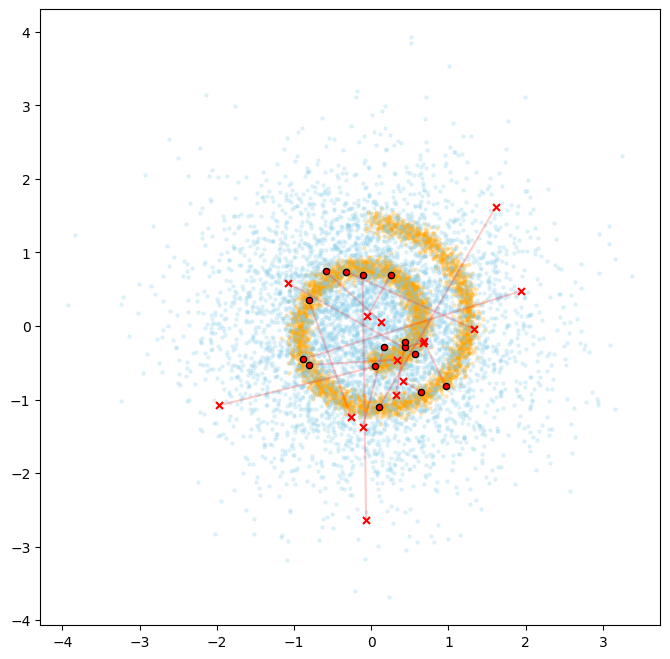

In [ ]:
visualize_sampling_cond_from_points_1to1(u_model, dataset_y, dataset_x, n=15,
                                    swap_colors=True, scale_axis=False, title="")

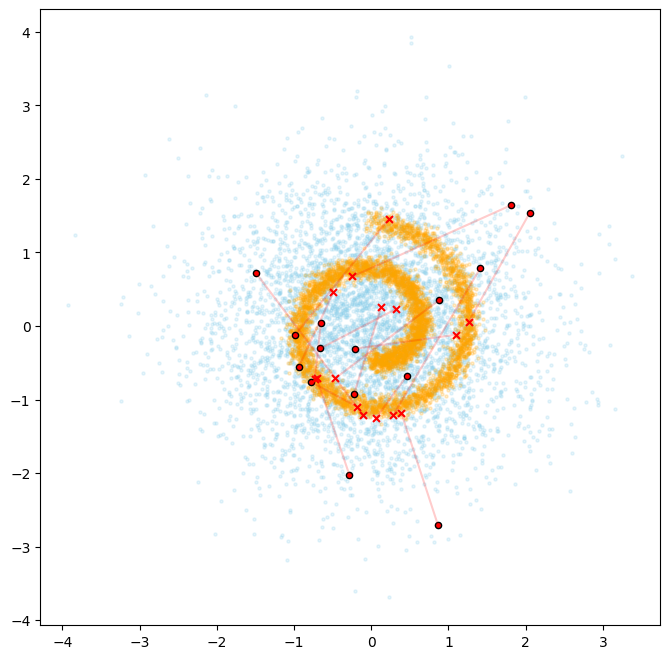

In [ ]:
visualize_sampling_cond_from_points_1to1(v_model, dataset_x, dataset_y, n=15,
                                         swap_colors=False, scale_axis=False, title="")